In [1]:
import math
import os

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [24]:
labels = '/home/mike/Downloads/Innovation Week 2019/training-labels.csv'
folder = '/home/mike/Downloads/Innovation Week 2019/Train/output_combined2/'
save_folder = '/home/mike/Downloads/Innovation Week 2019/Train/299/'
test_folder = '/home/mike/Downloads/Innovation Week 2019/Test/'
test_save_folder = '/home/mike/Downloads/Innovation Week 2019/Test/299/'
fill_type = 'mix'  # crop, pad, mix
process_test = False
# im_size = 224
im_size = 299

# # 2015 dataset
# labels = '/home/mike/Downloads/Innovation Week 2019/2015_data/trainLabels.csv'
# folder = '/home/mike/Downloads/Innovation Week 2019/2015_data/Train/train/'
# save_folder = '/home/mike/Downloads/Innovation Week 2019/2015_data/Train/299/'

# # 2015 dataset - test
# labels = '/home/mike/Downloads/Innovation Week 2019/2015_data/retinopathy_solution.csv'
# folder = '/home/mike/Downloads/Innovation Week 2019/2015_data/Test/test/'
# save_folder = '/home/mike/Downloads/Innovation Week 2019/2015_data/Test/299/a/'

# # 2019 aptos dataset
labels = '/home/mike/Downloads/Innovation Week 2019/aptos2019_data/train.csv'
folder = '/home/mike/Downloads/Innovation Week 2019/aptos2019_data/Train/train/'
save_folder = '/home/mike/Downloads/Innovation Week 2019/aptos2019_data/Train/299/'

os.makedirs(save_folder, exist_ok = True)
os.makedirs(test_save_folder, exist_ok = True)

In [3]:
label_df = pd.read_csv(labels)
label_df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [4]:
def crop_image(im, amount_to_crop = None):
    w, h = im.size
    if amount_to_crop is None:
        amount_to_crop = abs(w - h)
    if h < w:
        l, r = math.floor(amount_to_crop/2), math.ceil(amount_to_crop/2)
        im = im.crop((l, 0, w-r, h))  # (left, upper, right, lower)
    elif w < h:
        t, b = math.floor(amount_to_crop/2), math.ceil(amount_to_crop/2)
        im = im.crop((0, t, w, h-b))
    return im

def pad_image(im, pad_ratio = 1):
    w, h = im.size
    size_diff = max(w, h) - min(w, h)
    new_size = min(w, h) + size_diff // pad_ratio  # No need to crop first
#     if pad_ratio != 1:
#         amount_to_crop = max(w, h) - new_size
#         im = crop_image(im, amount_to_crop = amount_to_crop)
#         w, h = im.size
    new_im = Image.new('RGB', (new_size, new_size))  # Black by default
    t = math.floor((new_size - h)/2)
    l = math.floor((new_size - w)/2)
    new_im.paste(im, box = (l,t))  # Upper left corner
    return new_im

def preprocess_image(image_path, fill_type = 'crop', desired_size = im_size):
    im = Image.open(image_path)
    try:
        if fill_type == 'crop':
            im = crop_image(im)
        elif fill_type == 'pad':
            im = pad_image(im, pad_ratio = 1)
        elif fill_type == 'mix':
            im = pad_image(im, pad_ratio = 2)
    except:
        plt.imshow(im)
        plt.show()
    im = im.resize((desired_size, )*2, resample = Image.LANCZOS)
    return im

In [5]:
def update_progress(progress):
    barLength = 50
    progress = min(max(progress, 0), 1)
    block = int(round(barLength * progress))
    text = "\rPercent: [{0}] {1:.1f}%".format( "#" * block + "-" * (barLength - block), progress * 100)
    print(text, end = '', flush = True)

In [6]:
N = len(label_df)
print("Files:", N)
x_train = np.empty((N, im_size, im_size, 3), dtype = np.uint8)
y_train = np.empty((N,), dtype = int)

for i in range(N):
    file, group = label_df.loc[i]
    if not (file.endswith('.tif') or file.endswith('.jpeg') or file.endswith('.jpg') or file.endswith('.png')):
        if os.path.exists(os.path.join(folder, file + '.tif')):
            file += '.tif'
        elif os.path.exists(os.path.join(folder, file  + '.jpeg')):
            file += '.jpeg'
        elif os.path.exists(os.path.join(folder, file + '.jpg')):
            file += '.jpg'
        elif os.path.exists(os.path.join(folder, file + '.png')):
            file += '.png'
        else:
            print("Check file extension")
    x_train[i, :, :, :] = preprocess_image(os.path.join(folder, file), fill_type = fill_type)
    y_train[i] = group
    if i % 10 == 0:
        update_progress(i / N)

Files: 3662
Percent: [##################################################] 99.9%

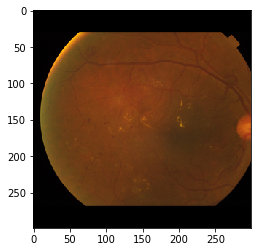

In [7]:
plt.imshow(x_train[0])

In [8]:
np.save(os.path.join(save_folder, 'x_{}.npy'.format(fill_type)), x_train)

In [9]:
y_one_hot = pd.get_dummies(y_train).values
y_train_multi = np.empty(y_one_hot.shape, dtype = int)
y_train_multi[:, 4] = y_one_hot[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_one_hot[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_one_hot.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [1805  370  999  193  295]
Multilabel version: [3662 1857 1487  488  295]


In [10]:
np.save(os.path.join(save_folder, 'y_{}.npy'.format(fill_type)), y_one_hot)
np.save(os.path.join(save_folder, 'y_multi_{}.npy'.format(fill_type)), y_train_multi)

In [25]:
########
# Test set
if process_test:
    files = []
    number = []
    for f in sorted(os.listdir(os.path.join(test_folder, 'Test'))):
        if f.endswith('.tif') or f.endswith('.jpeg') or f.endswith('.jpg'):
            files.append(f)
            number.append(int(f.split('.')[0][10:]))
        else:
            print(f)

    number_dict = dict(zip(files, number))
    files = sorted(files, key = number_dict.get)

Files: 999
Percent: [##################################################] 99.6%

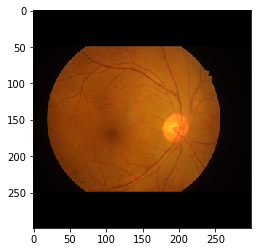

In [26]:
if process_test:
    N = len(files)
    print("Files:", N)
    x_test = np.empty((N, im_size, im_size, 3), dtype = np.uint8)

    i = 0
    for file in files:
        x_test[i, :, :, :] = preprocess_image(os.path.join(test_folder, 'Test', file), fill_type = fill_type)
        i += 1
        if i % 5 == 0:
            update_progress(i / N)
    
    plt.imshow(x_test[-1])

In [27]:
if process_test:
    np.save(os.path.join(test_save_folder, 'test_x_{}.npy'.format(fill_type)), x_test)
    pd.DataFrame(files).to_csv(os.path.join(test_save_folder, 'test_files.csv'), index = None, header = None)